# Введение в нейронные сети

<img src="./imgs/1.png">

# Машинное обучение

> Говорят, что компьтерная программа обучается решению задачи T на основе опыта E, если качество решения по метрике P растет по мере накопления опыта E. (_Mitchell "Machine learning", 1997_)

### Задача T

В машинном обучении, под этими терминам обычно подразумевают следующее:
- задача Т: это то, что мы должны сделать с **объектами (examples)**, которые обычно представленны в виде векторов **признаков (features)**

Среди наиболее популярных задач T, интересных нам в курсе, выделяют:
- **регрессию** - предсказание непрерывной переменной (_цены на недвижимость_)
- **классификацию** - предсказание класса объекта (_определение марки авто по фотографии_)
- **кластеризация** - группировка данных (_разбиение потока новостей на сюжеты_)
- **обучение с подкреплением** - обучение игре на основе опыта (_игра в Го_)

Хороший обзор многих других методов можно найти в книге _Ian Goodfellow et. al. "[Deep Learning](http://www.deeplearningbook.org/contents/ml.html)", 2016_

### Метрика, P

> То что вы не можете измерить – вы не можете улучшить

Метрика показывает насколько хорошо данный алгоритм решает поставленную задачу. В простейшем случае с классификаций, самой просто метрикой может быть просто процент ошибок.

Важно понимать, что выбор метрики напрямую влияет на решение задачи. Если метрика будет выбрана не корректно, то задача может быть плохо решена или вовсе не решена.

### Опыт, E

Все алгоритмы можно разделить на 2 большие группы:
- обучение без учителя
- обучение с учителем

В обоих случаях опыт представляется набором объектов (**dataset**). В случае обучения без учителя задача сводится к поиску некоторых закономерностей в наборе данных. Если мы говорим про обучение с учителем, то кроме самих объектов даны **метки (targets, labels)**, которые нужно научиться предсказывать.

# Лирическое отступление

В нашем курсе мы будем постоянно использовать ряд библиотек, такие как numpy, pandas, seaborn и т.д. Если вы с ними не знакомы, настоятельно рекомендуем изучить их, например:
- [Первичный анализ данных с Pandas](https://habrahabr.ru/company/ods/blog/322626/) 
- [Визуализация данных c Python](https://habrahabr.ru/company/ods/blog/323210/)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import math
%matplotlib inline

In [2]:
# Многие примеры и алгоритмы используют генератор случайных чисел. 
# Чтобы решение было воспроизводимым не забывайте инициализировать генератор.
np.random.seed(102)

# Линейная регрессия

Рассмотрим один из простейший алгоритмов машинного обучения: __линейную регрессию__.

Нам нужно измерить коэффициент упругости пружины. Мы знаем, что растяжение пружины подчиняется закону Гука:
$$ F = k \Delta l $$

Проведя серию измерений для разных $\Delta l$ мы получаем следующую картинку:

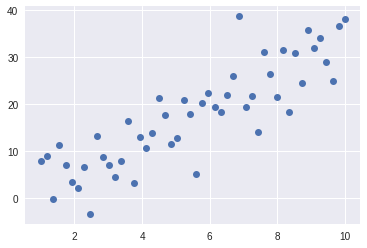

In [3]:
# Функция measure эмулирует процесс измерения: закон Гука + нормальный шум.
def measure(delta):
    return 3.14 * delta + np.random.normal(scale=5)

# Создаем 50 точек данных в интервале [1;50]
d = np.linspace(1,10, num=50)
f = np.vectorize(measure)(d)

# Рисуем то, что мы измерили.
plt.plot(d, f, 'o')

В задаче линейной регрессии мы предполагаем, что данные пораждаются следующим процессом:

$$ y = \vec{w}^T \vec{x} + \epsilon$$

- $y$ - целевая переменная
- $\vec{w}$ - вектор параметров модели
- $\vec{x}$ -  вектор признаков объекта
- $\epsilon \sim \mathcal{N}(0,\,\sigma^{2})
$ - случайная ошибка, полученная из нормального распределения с нулевым матожиданием

На выходе из эксперимента мы имеем набор данных из $N$ объектов $\{\vec{x}_n\}$ и соответствующие им результаты измерений $\{y_n\}$. Наша задача сводится к определению коэффициентов регрессии $\vec{w}$.

# Максимизация правдоподобия (likelihood)

Для решения этой задачи нам нужно определиться с метрикой качества, которая покажет степень соответствия данной модели и тренировочных данных. Для этого воспользуемся методом максимизации правдоподобия.

Правдоподобием называют вероятность того, что данная выборка была семплирована из данного распределения. Если объекты независимы и одинаково распределённы, то правдоподобие вычисляется как:
$$
    \mathcal {L}_\theta = \prod_{i=1}^{N} P_\theta(\vec{x}_i)
$$

Т.к. большенство распределений параметрические, правдоподобие удобно использовать для того, чтобы оценить параметры распределения из которого появилась выборка. Для этого нужно найти такое $\theta$ при котором правдоподобие будет максимальным. 

Посмотрим на нашу модель с вероятностной точки зрения.
<img src="./imgs/2.png" alt="Bishop, Pattern Recognition and Machine Learning, 2006" style="width: 500px;"/>

$$
\Large 
y = \mathbb{E}\left[ p(t|x,w,\sigma^{2}) \right]
$$

Выпишем фунцию правдоподобия для нашего набора данных. Сразу возьмем логарифм правдоподобия, т.к. он поможет нам избавиться от произведения и степени экспоненты в нормальном распределении
$$
\Large 
\begin{array}{rcl}
 ln\left(\mathcal {L}\right) 
              &=& \log \prod_{i=1}^{N} \mathcal{N}(\vec{w}^T \vec{x}_i,\,\sigma^{2}) \\
              &=& \sum_{i=1}^n \log \mathcal{N}\left( \vec{w}^T \vec{x}_i, \sigma^2 \right) \\ 
              &=& \sum_{i=1}^n \log \frac {1}{\sigma {\sqrt {2\pi}}}\;e^{-{\frac {(y_i-\vec{w}^T \vec{x}_i )^{2}}{2\sigma ^{2}}}} \\
              &=& -n \log \sigma {\sqrt {2\pi}} -\frac{1}{2\sigma^2} \sum_{i=1}^n 
                  \left(y_i - \vec{w}^T \vec{x}_i\right)^2
\end{array}
$$

Таким образом задача сводится к максимизации правдоподобия.
$$
\Large 
\begin{array}{rcl}
\hat{w} &=& \arg \max_{w} log\left(\mathcal {L}\right) \\ 
        &=& \arg \max_{w} -n \log \sigma {\sqrt {2\pi}} -\frac{1}{2\sigma^2} \sum_{i=1}^n \left(y_i - \vec{w}^T \vec{x}_i\right)^2 \\ 
        &=& \arg \min_{w} \sum_{i=1}^n \left(y_i - \vec{w}^T \vec{x}_i\right)^2 \\ 
\end{array}
$$

Таким образом, функция потерь для задачи линейной регрессии выглядит как:
$$
\Large
L\left(X, \vec{y}, \vec{w}\right) = \sum_{i=1}^n \left(y_i - \vec{w}^T \vec{x}_i\right)^2
$$

# Аналитическое решение

Для того, чтобы найти веса $\vec{w}$ приравняем к нулю производную функции потерь $L$

$$
\Large 
\begin{array}{rcl} 
\frac{\partial L}{\partial \vec{w}} = 0 
    &\Leftrightarrow& \vec{w} = \left(X^T X\right)^{-1} X^T \vec{y} 
\end{array}
$$

# Полиномиальная регрессия

На практике часто бывает так, что зависимость в данных имеет нелинейную природу. В таких случаях решением может быть линейная комбинация нелинейных признаков:
$$
    y = w_0 + w_1 \phi_1(\vec{x}) + w_2 \phi_2(\vec{x})
$$

В простейшем случае функцией $\phi$ может быть возведение в $i$-ю степень. Тогда мы получаем так называемую полиномиальню регрессию
$$
    y = w_0 + w_1 x^1 + w_2 x^2 + w_3 x^3 + ... + w_p x^p
$$

Давайте попробуем при помощи полиномиальной регрессии востановить функцию синуса.

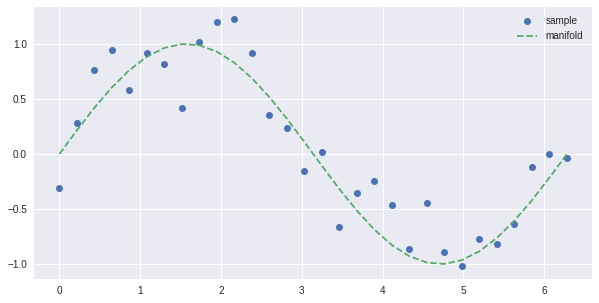

In [4]:
# Инициализируем график и генератор случайных чисел
plt.figure(figsize=(10,5))
np.random.seed(108)

# Генерируем точки данных
x = np.linspace(0, 2*3.14, num=30)
y = np.sin(x) + np.random.normal(0, 0.3, size=x.shape[0])

# Строим график
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

Пробуем востановить зависимость для степеней полинома 2, 4, 10

Degree: 2, Loss: 2.71630052849
Degree: 4, Loss: 1.32628668974
Degree: 10, Loss: 0.909448300852


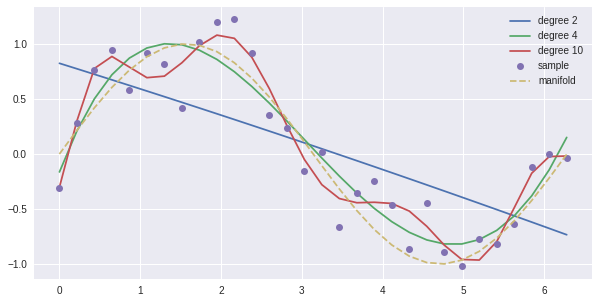

In [5]:
plt.figure(figsize=(10,5))

# Данная функция для входного вектора признаков х генерирует все полиномиальные признаки степени p
def power_features(x, p):
    return np.array( [np.ones(x.shape[0])] + list(map(lambda n: x**n, range(1, p + 1))) ).T

# Строим регрессии степени 2, 4, 10
for degree in [2,4,10]:
        
    # решаем задачу
    X = power_features(x, degree)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    
    # визуализируем результат
    y_hat = np.dot(w, X.T)
    plt.plot(x, y_hat, label='degree %s' % degree)
    print('Degree: %s, Loss: %s' % (degree, np.linalg.norm(y - y_hat, 2)))
    
# Нарисуем исходные данные
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

Визуально видно, что регрессия 4й степени неплохо приближает реальную зависимость. При этом увеличение степени полинома до 10 еще больше уменьшает loss на трейне. Но визуально мы видим, что наш результат стал хуже. Данное явление называется переобучение.

Для контроля за переобучением данные случайным образом разделяют на 2 части: **обучающую** и **тестовую** выборки.

Degree: 2, train loss: 2.52547470041, test loss: 1.07867936947
Degree: 4, train loss: 1.00666620901, test loss: 0.922039331463
Degree: 8, train loss: 0.644149338266, test loss: 1.01585448141


/home/voropaev/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


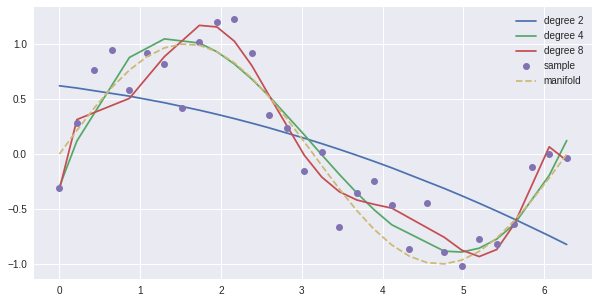

In [6]:
# В библиотеке sklearn есть функция для разбиения обучающего множества на train и test
from sklearn.cross_validation import train_test_split

# Настраиваем график
plt.figure(figsize=(10,5))

# Делим данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test \
    = train_test_split(x, y, random_state=10)

# Тут храним порядок, в котором нужно рисовать точки на графике, чтобы получилась нормальная линия.
order = np.argsort(x_train)

# Тут храним значения функций потерь на трэйне и тесте для разных значений полинома.
train_loss = []
test_loss = []

for degree in [2,4,8]:
    
    # решаем задачу
    X = power_features(x_train, degree)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_train)
    
    # считаем значения функций потерь
    y_hat = np.dot(w, X.T)
    X_test = power_features(x_test, degree)
    y_hat_test = np.dot(w, X_test.T)
    train_l = np.linalg.norm(y_train - y_hat, 2)
    test_l = np.linalg.norm(y_test - y_hat_test)
    
    # визуализируем результат
    print('Degree: %s, train loss: %s, test loss: %s' % (degree, train_l , test_l ))
    plt.plot(x_train[order], y_hat[order], label='degree %s' % degree)

# Нарисуем исходные данные
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

Обычно график ошибок на обучающем и тестовом множестве выглядят как так:
<img src="./imgs/3.png" alt="" style="width: 600px;"/>

Нужно понимать, что значение метрики это тоже случайная величина. Ее случайность определяется ограниченностью этой выборки. Более того, на практике размер тестового множества пытаются сделать как можно меньше, чтобы сберечь данные для обучения.

Для решения этой проблемы используют метод перекрестной проверки (k-fold cross validation). Для каждого значения метапараметра мы строим k моделей, используя в качестве теста разные куски исходного набора данных. Затем полученные на тесте ошибки усредняются.

<img src="./imgs/4.png" alt="" style="width: 400px;"/>

# Регуляризация

Другой способ борьбы с переобучением - это регуляризация. Она достигается добавлением некоторой априорной информации к условию задачи. 

Для задачи линейной регресии часто используют $L^2$ регуляризацию:
$$
    L_{reg} \left(X, \vec{y}, \vec{w}\right) =\left\| \vec{y} - X \vec{w} \right\|_2^2  + \frac{\lambda}{2} \left\| \vec{w} \right\|_2^2
$$

Аналитическое решение для задачи регрессии с $L^2$ регуляризацией будет иметь следующий вид:
$$
\vec{w} = \left(X^T X + \lambda E\right)^{-1} X^T \vec{y} 
$$

Такая регрессия называется **гребневой регрессией (ridge regression)** из-за гребеня в мартице $X^T X$.

<img src="./imgs/5.png" alt="" style="width: 400px;"/>

Давайте посмотрим, как ведет себя решение для p=8 и разных значений $\lambda$

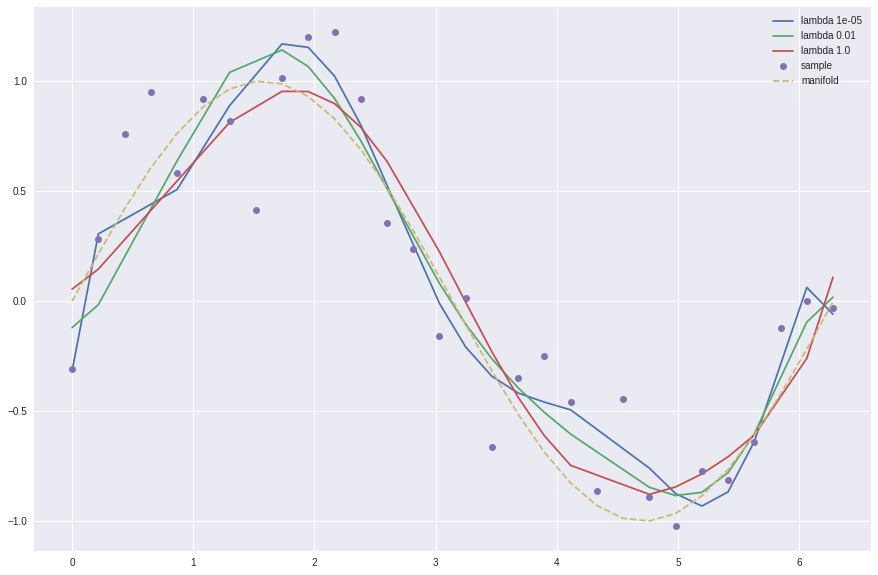

In [7]:
from sklearn.cross_validation import train_test_split
plt.figure(figsize=(15,10))

# Делим данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)
order = np.argsort(x_train)
train_loss = []
test_loss = []

# В данном примере мы фиксируем степень полинома, но смотрим решения для разных значений регуляризатора.
degree = 8
for lmd in [0.00001, 0.01, 1.]:
        
    # решаем задачу
    X = power_features(x_train, degree)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+lmd*np.eye(X.shape[1])), X.T), y_train)

    # визуализируем результат
    y_hat = np.dot(w, X.T)
    X_test = power_features(x_test, degree)
    y_hat_test = np.dot(w, X_test.T)
    train_l = np.linalg.norm(y_train - y_hat, 2)
    test_l = np.linalg.norm(y_test - y_hat_test)

    plt.plot(x_train[order], y_hat[order], label='lambda %s' % lmd)
        
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

# Задача классификации

В задаче классификации каждому объекту из обучающей выборки присваивается метка +1 или -1 в зависимости от класса. При этом мы хотим научится оценивать вероятность $P_+(\vec{x})$ принадлежности объекта к классу +1. Очевидно, что линейная регрессия нам здесь не поможет.

Для решения этой задачи рассмотрим такую вещь как шанс. Шансом называют
$$
OR_+ = \frac{P_+(x)}{1 - P_+(x)}
$$

В то время как значение вероятности лежит в диапазоне $[0,1]$, значение шанса лежит в диапазоне $[0,\infty]$. А логорифм шанса лежит в диапазоне $[-\infty,+\infty]$ и может быть приближен линейной моделью
$$
ln\left(OR_+(\vec{x})\right) = \vec{w} \vec{x}
$$

Теперь осталось совместить два определения и получить модель для $P_+(\vec{x})$
$$
P_+(\vec{x}) = \frac{OR_{+}(\vec{x})}{1 + OR_{+}(\vec{x})} = \frac{\exp^{\vec{w}^T\vec{x}}}{1 + \exp^{\vec{w}^T\vec{x}}} = \frac{1}{1 + \exp^{-\vec{w}^T\vec{x}}} = \sigma(\vec{w}^T\vec{x})
$$

где $\sigma$ это функция следующего вида: 
<img src="./imgs/6.png" alt="" style="width: 400px;"/>

Наглядно данный рисунок показывает, почему нельзя использовать линейную регрессию в классификации
<img src="./imgs/7.png" alt="" style="width: 700px;"/>

# Функция потерь для логистической регрессии

Давайте получим функцию потерь аналогичным образом, как мы это сделали с линейной регрессией.


логарифм правдоподобия
$$
\large 
\begin{array}{rcl} 
    \log P\left(\vec{y} \mid X, \vec{w}\right) 
        &=& \log \prod_{i=1}^{\ell} P\left(y = y_i \mid \vec{x_i}, \vec{w}\right) \\ 
        &=& \log \prod_{i=1}^{\ell} \sigma(y_i\vec{w}^T\vec{x_i}) \\ 
        &=& \sum_{i=1}^{\ell} \log \sigma(y_i\vec{w}^T\vec{x_i}) \\ 
        &=& \sum_{i=1}^{\ell} \log \frac{1}{1 + \exp^{-y_i\vec{w}^T\vec{x_i}}} \\ 
        &=& - \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}}) 
\end{array}
$$
который и будем оптимизировать. 

Данная функция потерь 
$$
\large L(\vec{x},\vec{y},\vec{w}) = \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}})
$$
называется **логистичской функцией потерь или сокращенно logloss**.

# Стохастичский градиентный спуск

Ранее мы рассмотрели вариант аналитического решения для линейной регрессии. Однако, существуют и другие методы оптимизации, основанные на итерационном подходе. Одним из наиболее успешных и распространенных методов является метод градиентного спуска. Рассмотрим его на примере обучения логистической регрессии.

Дано:
- X - обучающее множество
- Y - метки классов для обучающего множества
- $\eta$ - скорость обучения

Алгоритм:
1. инициализируем $\vec{w}_0$ небольшими случайными значениями
2. выбираем случайный объект $x_i$ с меткой $y_i$
3. обновляем веса $ \vec{w}_{t+1} = \vec{w}_{t} - \eta \nabla L $
4. если условие остановки не выполнело, возвращаемся к шагу 2

![image.png](./imgs/8.png)

На практике, в качестве условия остановки, часто используют изменение функции потерь на тестовой выборке.

# Практическое задание - ирисы Фишера

Для того, чтобы закрепить полученные знания, давайте решим одну из класических задачь классификации: ирисы Фишера (1936).

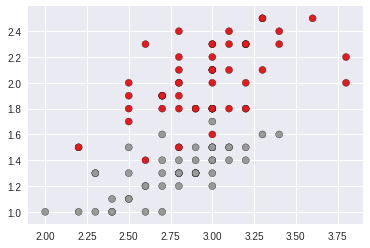

In [8]:
from sklearn import datasets

# Загружаем датасет 
iris = datasets.load_iris()

# ограничемся только двумя классами и двумя переменными
selector = iris.target != 0 
X = iris.data[:, [1,3]][selector]
y = iris.target[selector]

# конвертируем метки классов к 1/-1
y[y==2] = -1 

# рисуем данные на плоскости
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')

Первое что нужно сделать - это отнормировать входные данные.
$$
\hat{x_i} = \frac{ x_i - \mu } { \sqrt{\sigma + \epsilon} }
$$

Необходимость нормировки объясняется следующей картинкой:
![image.png](./imgs/9.png)

In [9]:
# Делаем нормировку данных
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

In [10]:
# Добавляем единичную колонку для w0, чтобы не считать байесы отдельно.
X = np.hstack([ np.ones((X.shape[0], 1)), X] )

In [11]:
# Инициализируем веса случайны образом, это важно для корректной работы градиентного спуска.
np.random.seed(11)
w = np.random.normal(scale=0.001, size = X.shape[1])

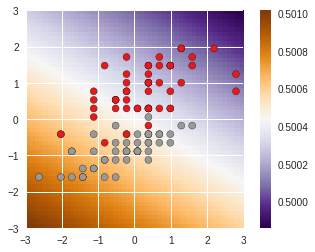

In [12]:
# Функция для отрисовки плотности вероятности нашей модели.
def draw_model(w, rx=3, ry=2, ft=None):
    xx, yy = np.meshgrid(np.linspace(-rx, rx, 50), np.linspace(-rx, rx, 50))
    Z = np.vstack([np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]).T
    if ft is not None:
        Z = ft.fit_transform(Z)
    p = (1. / (1. + np.exp(-np.dot(Z, w)))).reshape(xx.shape)
    plt.imshow(p, cmap=plt.cm.PuOr_r, extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin='lower')
    plt.colorbar()
    
# Нарисуем случайную модель
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.Set1, edgecolor='k')
draw_model(w)

Выпишем градиент функции потерь:
$$
    \nabla L = \left\{ - \frac{y_i \vec{x_i} }  { 1 + \exp^{y_i\vec{w}^T\vec{x_i}} } + \lambda \vec{w} \right\} 
$$

Делаем 10 итераций градиентного спуска.

[-0.43677222  0.79735614 -4.60196834] [ 0.18597175  0.07189852  0.05456307]


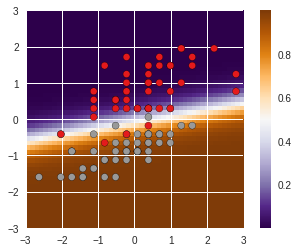

In [13]:
# цикл итераций. Иногда итерации называют эпохами.
for iter in range(100):
    # цикл по объектам обучающей выборки
    for i in range(X.shape[0]):
        #j = np.random.randint(0, X.shape[0])
        grad = - y[i] * X[i] / \
            ( 1 + math.exp( y[i] * np.dot(w.T, X[i]) ) ) + 0 * w
        w = w - 0.01 * grad
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.Set1, edgecolor='k')
print(w, grad)
draw_model(w)

# Проблема XOR

![image.png](./imgs/10.png)

Как мы видим, нельзя построить линейную плоскость, которая разделить 2 класса.  Но мы упертые и попробуем это сделать.

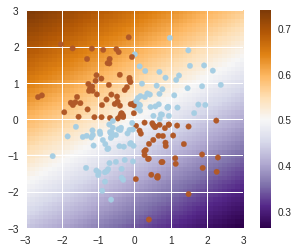

In [14]:
# Генерируем набор данных
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

# Cтроим регрессию использую библиотеку sklearn
from sklearn.linear_model import LogisticRegression
X = np.hstack([ np.ones((X.shape[0], 1)), X] )
logreg = LogisticRegression()
logreg.fit(X, y)

# Рисуем результат
draw_model(logreg.coef_[0])

# Решение XOR через полиномиальные признаки

Полиномиальные признаки:
$$
x_1, x_2, x_1x_2, x_1^2, x_2^2,...
$$

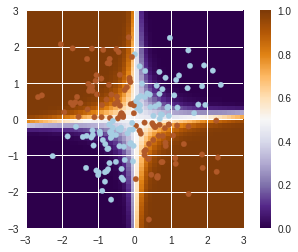

In [15]:
# В библиотеке sklearn есть много инструментов для подготовки данных и построению цепочек обработки данных.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Строим полиномиальную регрессию второй степени.
ft = PolynomialFeatures(degree=2)
XX = ft.fit_transform(X)
logreg.fit(XX, y)

# Рисуем результат
plt.scatter(X[:, 1], X[:, 2], s=30, c=y, cmap=plt.cm.Paired);
draw_model(logreg.coef_[0], ft=ft)

# Многослойный персептрон - Feature learning (c)

А что, если в качестве преобразователя признаков взять обучаемую модель? Например логистическую регрессию?

![image.png](./imgs/11.png)
$$
y(\vec{x}) = \sigma \left( \sum_i w_i g_i(\vec{x}) \right) \\
g_i(\vec{x}) = \sigma \left( \sum_j w_ij x_j \right)
$$

Можно делать штуки повеселее )

![image.png](./imgs/12.png)

# В следующей серии

Мы поговорим:
- о том, как обучить многослойный персептрон алгоритмом обратного распространения ошибки
- поговорим о затухании и взрыве градиентов
- о видах функции актвации и типах нейронных сетей
- обсудим, наконец, что такое deep learning и насколько он глубок
- сделаем первую распозновалку цифр

**Stay tuned!!!**
<img src="./imgs/13.png" alt="" style="width: 200px;"/>

# Чеклист

- модель
- алгоритм обучения
- метрика качества
- обучение с учителем и без
- тренирочный датасет
- модель линейной регрессии
- правдоподобие
- как из правдоподобия получается MSE
- решение оптимизационной задачи линейной регрессии
- переобучение
- регуляризация
- задача классификации, модель логистической регрессии
- вывод logloss через правдоподобие
- оптимизация градиентным спуском
- подготовка данных для градиентного спуска
- проблема XOR
- понятие feature learning
- многослойный персептрон
- синаптические веса, функция активации

# Почитать вечерком

Годный habr:
- хороший обзор библиотек [pandas](https://habrahabr.ru/company/ods/blog/322626/) и [библиотек для визуального анализа](https://habrahabr.ru/company/ods/blog/323210/).
- [Открытый курс машинного обучения. Тема 4. Линейные модели классификации и регрессии](https://habrahabr.ru/company/ods/blog/323890/)
- [Базовые принципы машинного обучения на примере линейной регрессии](https://habrahabr.ru/company/ods/blog/322076/)

Книги:
- Ian Goodfellow and Yoshua Bengio and Aaron Courville, [Deep Learning](http://www.deeplearningbook.org/contents/ml.html), 2016 
- Hastie et.al., [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf), 2003
- Bishop, [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf), 2006

# Персептрон и алгоритм обратного распространения ошибки.  

Illustration of the Mark 1 perceptron hardware (1960).

<img src="./imgs/2-0.png">
The photograph on the left shows how the inputs were obtained using a simple camera system in which an input scene, in this case a printed character, was illuminated by powerful lights, and an image focussed onto a 20 × 20 array of cadmium sulphide photocells, giving a primitive 400 pixel image. 
<img src="./imgs/2-1.png">
The perceptron also had a patch board, shown in the middle photograph,
which allowed different configurations of input features to be tried. Often these were wired up at random to demonstrate the ability of the perceptron to learn without the need for precise wiring, in contrast to a modern digital computer. 

<img src="./imgs/2-2.png">
The photograph on the right shows one of the racks of adaptive weights. Each weight was
implemented using a rotary variable resistor, also called a potentiometer, driven by an electric motor thereby
allowing the value of the weight to be adjusted automatically by the learning algorithm.

<img src="./imgs/2-2.jpg">
The Mark 1 Perceptron (Source: Arvin Calspan Advanced Technology Center; Hecht-Nielsen, R. Neurocomputing (Reading, Mass.: Addison-Wesley, 1990).)



# Однослойный перцептрон

<img src="./imgs/2-3.png" width=400>

$$
\large
\large OUT(x) = softmax(D_2(\vec{x})) \\
\large D_2(\vec{x}) = \theta_2 + W_2 A_1(\vec{x}) \\
\large A_1(x) = max(0, D_1(\vec{x})) \\
\large D_1(\vec{x}) = \theta_1 + W_1 \vec{x}
$$

Каждая сеть представима в виде акцикличного графа вычислений над тензорами. **Тензор** - в случае нейронных сетей это просто многомерный массив. В узлах графа находятся функции, осуществляющие операции. В техминах нейронных сетей вычислительные узлы называют **слоями**. В данной сети есть слои следующих видов:
- dense (D) - полносвязный слой
- max(0,x) - слой нелинейной активации
- softmax - softmax 
- loss - функционал потерь, котороый тоже стоит рассматривать как слой.

Обычно граф вычислений рисуется следующим образом

<img src="./imgs/2-4.png" width=700>

Так как мы говорим про задачу многоклассовой классификации, то на выходе сети мы ожидаем набор вероятностей $p_i$, такие что $\sum p_j = 1$. Для реализации этого используется softmax слой, физический смысл которого эквивалентен сигмойду в задаче бинарной классификации
$$
\large softmax_i = p_i = \frac{e^{a_i}}{\sum_j e^{a_j}} \\
$$

# Loss функция

Для того, чтобы получить loss функцию для нейронной сети, рассмотрим понятие перекрестной энтропии:
$$
\large H(p, q) = \operatorname{E}_p[-\log q] = H(p) + D_{\mathrm{KL}}(p \| q)=-\sum_x p(x)\log q(x)
$$
где $D_{\mathrm{KL}}(p||q)$ - расстояние Ку́льбака—Ле́йблера
$$
\large D_{\mathrm{KL}}(p||q)=\sum \limits _{i=1}^{n}p_{i}\log {\frac {p_{i}}{q_{i}}}
$$
Значение этого функционала можно понимать как количество неучтённой информации распределения $P$, если $Q$ было использовано для приближения $P$.

Можно показать, что оптимизация кросс-энтропии в задаче многоклассовой оптимизации эквивалентно оптимизации правдоподобия.  Таким образом, loss для нашей сети будет:
$$
\large L = -\sum_i y_i \log \hat{y}_i
$$

# Концепция автоматического дифференцирования

Давайте переместимся в слайды )
<img src="./imgs/2-5.png" width=700>

# Обучаем персептрон

Задача: нужно реализовать двухслойный персептрон и обучить его на наборе MNIST

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Нелинейная функция активации: ReLu

- Функция активации не обязательно должна быть сигмойдом.
- Сегодня самой популярной является функция **ReLU (rectified linear unit)**

$$
ReLu = max(0, Dense(x))
$$

In [17]:
# Каждый блок нейронной сети должен содержать 2 метода:

class ReLu:
    
    # forward - прямой проход через блок. Тут мы непосредственно делаем вычисления.
    def forward(self, x):
        # Сохраняем вход блока, чтобы потом мы могли сделать обратный проход.
        self.x = x
        # Делаем вычисления
        return np.maximum(0, x)
    
    # backward решает 2 задачи:
    # - вычисляет градиент лосса относительно своего входа и передает его дальше.
    # - обновляет параметры блока для минимизации лосса (если они есть)
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

### Softmax

Softmax - это вариант сигмойда для многоклассовй классификации.
$$
\sigma_j(\mathbf{x}) = \frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}}
$$

Производная softmax вычисляется как:
$$
\frac {\partial }{\partial x_{k}}\sigma_i (x) =\sigma_i (x)(\delta _{ik}-\sigma_k (x))
$$
где $\delta _{ik}$ это дельта Кронекера
$$
\delta _{{ij}}={\begin{cases}0&{\text{if }}i\neq j,\\1&{\text{if }}i=j.\end{cases}}
$$

In [44]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [19]:
# Код для проверки
x = np.array([1, -1])
s = Softmax()
sm = s.forward(x)
print(sm)
dz = np.array([0, -2.])
print('dz', s.backward(dz))
print(s.lp)
print(s.lp2)

[ 0.88079708  0.11920292]
dz [ 0.20998717 -0.20998717]
[[ 0.11920292 -0.88079708]
 [-0.11920292  0.88079708]]
[[ 0.10499359 -0.10499359]
 [-0.10499359  0.10499359]]


### Loss: кросс-энтропия

Напомню, кросс-энтропия выражается как
$$
L = -\sum_i y_i \log \hat{y}_i
$$

Градиент вычисляется следующим образом:
$$
\frac {\partial }{\partial \hat{y}_{i}} L = -\frac{y_i}{\hat{y}_i}
$$

In [20]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

### TODO: Полносвязный слой

Полносвязный слой определяется простой формулой $$ y = w x + b $$

В качестве ДЗ вам будет нужно самому реализовать этот слой.

In [21]:
class Dense:
    def __init__(self, in_size, out_size):
        # TODO
        pass
        
    def forward(self, x):
        # TODO 
        pass
    
    def backward(self, dz, lr=0.001):
        # TODO
        pass

In [22]:
# я хитрый, чтобы показать как это работает я испортирую этот класс из скрытой реализации
from hiden import Dense

# Тест 0 - самая тупая сеть

Строим функцию $f(x)=x$

In [23]:
X = np.array([[1., 0],
              [0,  1.]])
Y = np.array([[1., 0],
              [0,  1.]])

In [24]:
class IdentityNet:
    
    def __init__(self):
        self.d = Dense(2, 2)
        self.s = Softmax()
        
    def forward(self, x):
        self.x = x
        net = self.d.forward(x)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr=0.001):
        dz = self.s.backward(dz, lr)
        dz = self.d.backward(dz, lr)
        return dz

[ 0.95114643  0.04885357] [ 0.05347249  0.94652751]


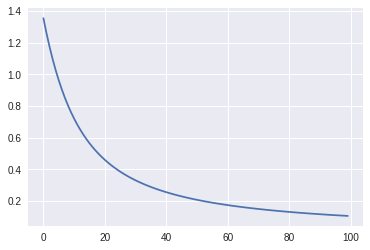

In [25]:
def train(net, loss, lr, n_epoch):
    # тут будем копить loss в зависимости от эпохи
    L_iter = [] 
    # итерации по эпохам
    for epoch in range(n_epoch):
        L_acc = 0.
        for i in range(X.shape[0]):
            # делаем forward pass
            y_h = net.forward(X[i])
            # делаем forawrd лосса, тем самым его вычисляя
            L_acc += loss.forward(Y[i], y_h)
            # делаем backward лосса. 
            # обратите внимание, что стартовый градиент == 1
            dz = loss.backward(1, lr)
            # backward сети, градиент берем из лосса.
            net.backward(dz, lr)
        L_iter.append(L_acc) # коллекционируем loss
    return L_iter

# Инициализируем loss, его удобнее хранить в теле обучения
loss = CrossEntropy() 
net = IdentityNet()
lr = 0.1
L_iter = train(net, loss, lr, 100)

plt.plot(L_iter) # посмотрим на кривую обучения
print( net.forward(X[0]), net.forward(X[1])) # проверим глазами, что обучились

# Тест 3 - MNIST

In [26]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
print(X.shape)

(70000, 784)


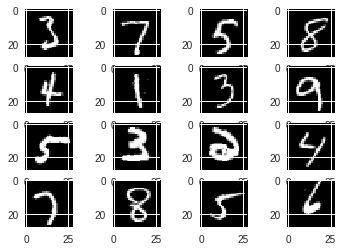

In [27]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

# Pytorch. Tensors.

Оригинал: http://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html

Тензора - это просто многомерные массивы, аналогичные массивам numpy. Основной профит их использованиея - это возможность прозрачно работать с этими тензорами на GPU.

In [28]:
%%bash
#conda install pytorch torchvision -c soumith

### Tensors

Создаем тензор размера (5 x 7) с не инициализированной памятью. 

In [29]:
import torch
a = torch.FloatTensor(5, 7)

Инициализируем тензор нормальным рандомом с параметрами mean=0, var=1:

In [30]:
a = torch.randn(5, 7)
print(a)
print(a.size())


-1.1135  1.0955 -0.2993  0.2490  0.3557 -0.1538 -0.8750
 0.7159 -0.8573 -0.7396  1.5941 -0.9240  0.5163 -0.5967
 0.1710  0.8260 -0.1579 -0.2440 -1.1179  0.4392 -0.0775
-0.5218 -0.3215  0.2259 -0.4254  0.8679  0.4410  0.7150
 1.0956  1.3137  1.8783  0.6105  1.2639 -0.0005  0.1616
[torch.FloatTensor of size 5x7]

torch.Size([5, 7])


### Inplace / Out-of-place

- все Inplace операции имеют окончание ``_``, например ``add_``
- операции без окончания - out-of-place

In [31]:
a.fill_(3.5)
# a заполнено значением 3.5

b = a.add(4.0)
# a все так же содержит 3.5
# новый тензор b содержит 3.5 + 4.0 = 7.5

print(a, b)


 3.5000  3.5000  3.5000  3.5000  3.5000  3.5000  3.5000
 3.5000  3.5000  3.5000  3.5000  3.5000  3.5000  3.5000
 3.5000  3.5000  3.5000  3.5000  3.5000  3.5000  3.5000
 3.5000  3.5000  3.5000  3.5000  3.5000  3.5000  3.5000
 3.5000  3.5000  3.5000  3.5000  3.5000  3.5000  3.5000
[torch.FloatTensor of size 5x7]
 
 7.5000  7.5000  7.5000  7.5000  7.5000  7.5000  7.5000
 7.5000  7.5000  7.5000  7.5000  7.5000  7.5000  7.5000
 7.5000  7.5000  7.5000  7.5000  7.5000  7.5000  7.5000
 7.5000  7.5000  7.5000  7.5000  7.5000  7.5000  7.5000
 7.5000  7.5000  7.5000  7.5000  7.5000  7.5000  7.5000
[torch.FloatTensor of size 5x7]



Некоторые операции (например ``fill_``) имеют только одну форму.

Тензора могут индексироваться слайсингом.

In [32]:
b = a[:, 3:5]  # selects all rows, 4th column and  5th column from a
b


 3.5000  3.5000
 3.5000  3.5000
 3.5000  3.5000
 3.5000  3.5000
 3.5000  3.5000
[torch.FloatTensor of size 5x2]

### Numpy Bridge

Тензора можно легко конвертировать в массивы numpy и обратно. Память будет шариться, так что изменение в одном месте поменяют значения в другом.


In [33]:
a = torch.ones(5)
print(a)


 1
 1
 1
 1
 1
[torch.FloatTensor of size 5]



In [34]:
b = a.numpy()
print(b)

[ 1.  1.  1.  1.  1.]


In [35]:
a.add_(1)
print(a)
print(b) 	# see how the numpy array changed in value


 2
 2
 2
 2
 2
[torch.FloatTensor of size 5]

[ 2.  2.  2.  2.  2.]


In [36]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

[ 2.  2.  2.  2.  2.]

 2
 2
 2
 2
 2
[torch.DoubleTensor of size 5]



### CUDA

Обычные и CUDA тензора это разные классы, но они могут быть легко конвертированны друг в друга.


In [37]:
# проверяем, что CUDA доступна
if torch.cuda.is_available():
    # создаем LongTensor и копируем его на GPU
    a = torch.LongTensor(10).fill_(3).cuda()
    print(type(a)) #torch.cuda.LongTensor
    # Копируем обратно на CPU
    b = a.cpu()

# Pytorch. Autograd.

Оригинал: http://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html


Autograd
========

Autograd это система автоматического дифференцирования pytorch, которая лежить в основе реализации алгоритмов обучения методом градиентного спуска.


Variable
--------

В основе autograd лежит класс ``Variable``, который является враппером вокруг 
класса ``Tensor``. Доступ к тензору можно получить через атрибут ``.data``.

После выполнения обратного прохода в атрибует ``.grad`` будет храниться градиент относительно этой переменной.

<img src="./imgs/Variable.png">

Вторым по важности концептом является класс ``Function``. 
Совместно к классом ``Variable`` они образуют ациклический граф вычислений, в 
котором и сохраняется вся история вычислений. 

Для вычисления производной нужно вызвать метод ``.backward()`` у класса ``Variable``, 
все остальное сделает pytorch.


In [38]:
import torch
from torch.autograd import Variable
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [39]:
print(x.grad, x.creator)

None None


Делаем вычисление


In [40]:
y = x + 2
print(y)

Variable containing:
 3  3
 3  3
[torch.FloatTensor of size 2x2]



y был поражден операцией, так что у него есть создатель

In [41]:
print(y.creator)

Еще операции над y:



In [42]:
z = y * y * 3
out = z.mean()

print(z, out)

Variable containing:
 27  27
 27  27
[torch.FloatTensor of size 2x2]
 Variable containing:
 27
[torch.FloatTensor of size 1]



Gradients
---------

теперь посчитаем бэкпроп d(out)/dx



In [43]:
out.backward()
print(x.grad)

Variable containing:
 4.5000  4.5000
 4.5000  4.5000
[torch.FloatTensor of size 2x2]



# Чеклист

- устройство многослойного персептрона
- слои: полносвязный, ReLu, Softmax, CrossEntropy
- chain rule
- правило дифференцирования сложной функции
- алгоритм обратного распространения ошибки
- почему при обучении сеть потребляет больше памяти, чем при выводе
- тензора pytorch
- система autograd

# Почитать

Backprop: лекция в cs231n
- почитать: http://cs231n.github.io/optimization-2/
- посмотреть: https://www.youtube.com/watch?v=d14TUNcbn1k

Pytorch
- туториалы pytorch http://pytorch.org/tutorials/